In [2]:
# Bring in (new) PNC cohort

import pickle
from pathlib import Path
import numpy as np

newdir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/PNC'
newdemo = pickle.load(open(f'{newdir}/demographics.pkl', 'rb'))

fc = []
age = []
sex = []
race = []

for sub in newdemo['age_at_cnb']:
    for task in ['rest', 'nback', 'emoid']:
        f = f'{newdir}/fc/{sub}_task-{task}_fc.npy'
        if not Path(f).exists():
            continue
        if sub not in newdemo['Race'] or newdemo['Race'][sub] not in ['AA', 'EA']:
            continue
        p = np.load(f)
        a = newdemo['age_at_cnb'][sub]
        s = newdemo['Sex'][sub] == 'M'
        r = newdemo['Race'][sub] == 'AA'
        fc.append(p)
        age.append(a)
        sex.append(s)
        race.append(r)
        
age = np.array(age)
sex = np.array(sex)
race = np.array(race)
fc = np.stack(fc)

print(age.shape)
print(np.mean(age))
print(np.mean(sex))
print(np.mean(race))
print(fc.shape)

(3849,)
14.398285268901013
0.473629514159522
0.4811639386853728
(3849, 34716)


In [3]:
# Angle estimate

import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

pi = 3.14
pi2 = 2*pi

def tonp(t):
    return t.detach().cpu().numpy()

def fromnp(x):
    return torch.from_numpy(x).float().cuda()

def rmse(yhat, y):
    if isinstance(yhat, np.ndarray):
        f = np.mean
    else:
        f = torch.mean
    return f((y-yhat)**2)**0.5

class Jitter(nn.Module):
    def __init__(self, nsub):
        super(Jitter, self).__init__()
        self.nsub = nsub
        self.jit = nn.Parameter(torch.ones(nsub,264).float().cuda())
        
    def jitter(self):
        j0 = self.jit.unsqueeze(2)
        j1 = self.jit.unsqueeze(1)
        return j0*j1
    
    def jittervec(self):
        a,b = torch.triu_indices(264,264,offset=1)
        return self.jitter()[:,a,b]

    def project(self):
        with torch.no_grad():
            self.jit[self.jit < 0.1] = 0.1
            self.jit[self.jit > 1] = 1

    def forward(self):
        return self.jittervec()

class AngleBasis(nn.Module):
    def __init__(self, nbasis):
        super(AngleBasis, self).__init__()
        self.nbasis = nbasis
        self.thetas = nn.Parameter((pi*torch.rand(nbasis,264)+pi/2).float().cuda())
        
    def project(self):
        with torch.no_grad():
            self.thetas[:,50] = pi # Baseline
            self.thetas[self.thetas < 0] = 0
            self.thetas[self.thetas > pi2] = pi2
        
    def phases(self):
        t0 = self.thetas.unsqueeze(2)
        t1 = self.thetas.unsqueeze(1)
        return t0-t1
    
    def basis(self):
        t = self.phases()
        p = torch.cos(t)
        return p
    
    def basisvec(self):
        a,b = torch.triu_indices(264,264,offset=1)
        return self.basis()[:,a,b]
    
    def forward(self):
        return self.basisvec()
    
    def dump(self):
        return dict(mixn=self.nbasis, thetas=tonp(self.thetas), jit=tonp(self.jit))
    
print('Complete')

Complete


In [5]:
from itertools import chain

nepochs = 500
pperiod = 100

nsubs = 300

basis = AngleBasis(20)
jitter = Jitter(nsubs)
optim = torch.optim.Adam(chain(basis.parameters(), jitter.parameters()), lr=1e-2, weight_decay=0)

idcs = torch.randperm(fc.shape[0])
x = fc[idcs][:nsubs]
x = fromnp(x)

y = age[idcs][:nsubs]
mu = np.mean(y)
y -= mu
y = fromnp(y)

for e in range(nepochs):
    for n in range(0,nsubs,100):
        xb = x[n:(n+100)]
        yb = y[n:(n+100)]
        optim.zero_grad()
        b = basis()
        rw,_,_,_ = torch.linalg.lstsq(b.T, xb.T)
        with torch.no_grad():
            rw[rw < 0] = 0
        xhat = b.T@rw
        xhat = xhat.T*jitter()[n:(n+100)]
        loss = rmse(xhat, xb)
        (loss).backward()
        optim.step()
        basis.project()
        jitter.project()
        if e == nepochs-1 or e % pperiod == 0:
            with torch.no_grad():
                xx = torch.cat([rw.T, jitter.jit[n:(n+100)]], axis=1)
                yw,_,_,_ = torch.linalg.lstsq(xx, yb)
                yhat = xx@yw
                yloss = rmse(yhat, yb)
            print(f'{e} {float(loss)} {float(yloss)}')
        
print('Complete')

0 0.23006850481033325 8.387254638364539e-05
0 0.2207638919353485 0.0001242473954334855
0 0.22599665820598602 0.0001550822053104639
100 0.14206628501415253 1.1594061106734443e-06
100 0.13492687046527863 1.736319745759829e-06
100 0.13656248152256012 1.699856170489511e-06
200 0.14416082203388214 1.6524628563274746e-06
200 0.13745293021202087 1.9238477761973627e-06
200 0.13792116940021515 1.6158190874193679e-06
300 0.14405177533626556 2.2138733584142756e-06
300 0.14026539027690887 2.381168314968818e-06
300 0.15161114931106567 2.7625353595794877e-06
400 0.14452067017555237 1.339892037321988e-06
400 0.1380307674407959 2.1408213797258213e-06
400 0.14064356684684753 2.060808583337348e-06
499 0.14763322472572327 1.9793633327935822e-06
499 0.14071378111839294 1.7371379499309114e-06
499 0.1434679478406906 2.3646334739169106e-06
Complete


In [4]:
with torch.no_grad():
    xt = fc[idcs][nsubs:(nsubs+2000)]
    xt = fromnp(xt)
    yt = age[idcs][nsubs:(nsubs+2000)]
    yt -= mu
    yt = fromnp(yt)
    b = basis()
    rw,_,_,_ = torch.linalg.lstsq(b.T, xt.T)
#     rw[rw < 0] = 0
#     yw,_,_,_ = torch.linalg.lstsq(rw.T, yt)
    yhat = rw.T@yw
    yloss = rmse(yhat, yt)
    print(yloss)
    print(rmse(0, yt))

tensor(3.2103, device='cuda:0')
tensor(3.4221, device='cuda:0')


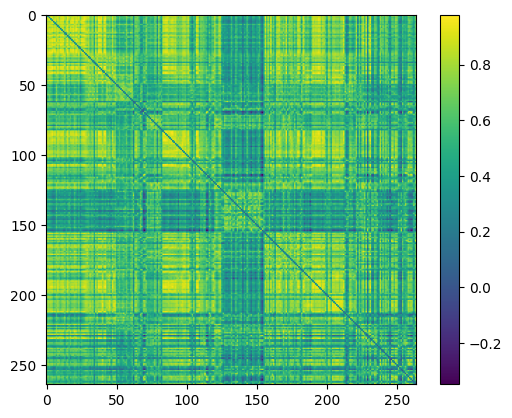

In [10]:
import matplotlib.pyplot as plt

plt.imshow(remap(vec2mat(tonp(xb[3]))))
# plt.imshow(remap(vec2mat(tonp(xhat[3]))))
# plt.imshow(remap(tonp(basis.basis()[0])))
# plt.imshow(remap(tonp(jitter.jitter()[3])))
plt.colorbar()
plt.show()

In [7]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete
